In [1]:
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:
print(train_data.shape)
test_data.shape

(150000, 3)


(50000, 3)

### 데이터의 중복 제거
NaN 결측치 제거 
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  #트레인 데이터 중 document 컬럼에서 중복값을 없앤다
    train_data = train_data.dropna(how = 'any') #트레인 데이터에 결측값이 하나라도 있으면 컬럼/행을 없앤다
    test_data.drop_duplicates(subset=['document'], inplace=True)#테스트 데이터도 동일하게 처리해준다
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) #가장 자주 쓰이는 단어 뽑기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] #<PAD>', '<BOS>', '<UNK>', '<UNUSED>앞에 넣어줌
    word_to_index = {word:index for index, word in enumerate(vocab)}

    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [5]:
print(len(X_train))
y_train.shape

146182


(146182,)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
len(word_to_index)

10000

#데이터셋의 문장길이 분포, 적절한 최대문장 길이 정하기 


In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens))) 

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
import tensorflow as tf
import os


vocab_size = len(word_to_index)  #딕셔너리에 포함된 단어 개수는 10000개
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)


output = embedding(X_train)
print(output) #shape=(146182, 6, 4)가 나온다.146182개의 문장의 최대길이가 maxlen 셋팅해준대로 20이다.  

tf.Tensor(
[[[ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  ...
  [ 2.00411193e-02  1.66910999e-02 -1.12161636e-02 -1.74712017e-03]
  [-2.59103179e-02  2.25047022e-03  1.45698525e-02  3.80454920e-02]
  [-7.74122775e-04  3.78214158e-02  4.58371639e-03  2.08605565e-02]]

 [[ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  ...
  [ 1.88941024e-02 -2.11507082e-03 -2.68253684e-02  4.71495055e-02]
  [ 3.24024297e-02  4.18163203e-02  3.49372737e-02  5.81470877e-03]
  [ 4.37856950e-02 -9.16314125e-03 -2.14557722e-03 -3.39389592e-02]]

 [[ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2.09689625e-02 -4.76070419e-02  4.51783054e-02]
  [ 4.97898348e-02  2

In [12]:
X_train.shape 

(146182, 41)

### 모델 만들기

In [13]:
vocab_size = 10000  #10000개의 사전 단어
word_vector_dim = 10  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 100,689
Trainable params: 100,689
Non-trainable params: 0
_________________________________________________________________


In [14]:
x_validation = X_train[:15000]   # 146182 중 약 10% 정도인 15000건을 validation 용도로 사용
y_validation = y_train[:15000]

#나머지를 다시 train 용도로 
partial_X_train = X_train[15000:]  
partial_y_train = y_train[15000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(131182, 41)
(131182,)


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

epochs=10

In [16]:
history = model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(x_validation, y_validation),verbose=1)

Epoch 1/10
257/257 [==============================] - 5s 7ms/step - loss: 0.5336 - accuracy: 0.7530 - val_loss: 0.3773 - val_accuracy: 0.8411
Epoch 2/10
257/257 [==============================] - 1s 5ms/step - loss: 0.3491 - accuracy: 0.8528 - val_loss: 0.3434 - val_accuracy: 0.8508
Epoch 3/10
257/257 [==============================] - 1s 6ms/step - loss: 0.3221 - accuracy: 0.8658 - val_loss: 0.3428 - val_accuracy: 0.8497
Epoch 4/10
257/257 [==============================] - 1s 5ms/step - loss: 0.3107 - accuracy: 0.8710 - val_loss: 0.3417 - val_accuracy: 0.8519
Epoch 5/10
257/257 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.8750 - val_loss: 0.3422 - val_accuracy: 0.8499
Epoch 6/10
257/257 [==============================] - 1s 5ms/step - loss: 0.2946 - accuracy: 0.8782 - val_loss: 0.3425 - val_accuracy: 0.8529
Epoch 7/10
257/257 [==============================] - 1s 5ms/step - loss: 0.2871 - accuracy: 0.8811 - val_loss: 0.3411 - val_accuracy: 0.8527
Epoch 

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
X_test

array([[   0,    0,    0, ...,    0,  832,  130],
       [   0,    0,    0, ...,    0,    0,    2],
       [   0,    0,    0, ..., 3557,   73,  917],
       ...,
       [   0,    0,    0, ...,    8,   12, 3424],
       [   0,    0,    0, ...,   67,  323,   43],
       [   0,    0,    0, ...,  179,   63, 1058]], dtype=int32)

In [19]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3656 - accuracy: 0.8471
[0.36557537317276, 0.847102165222168]


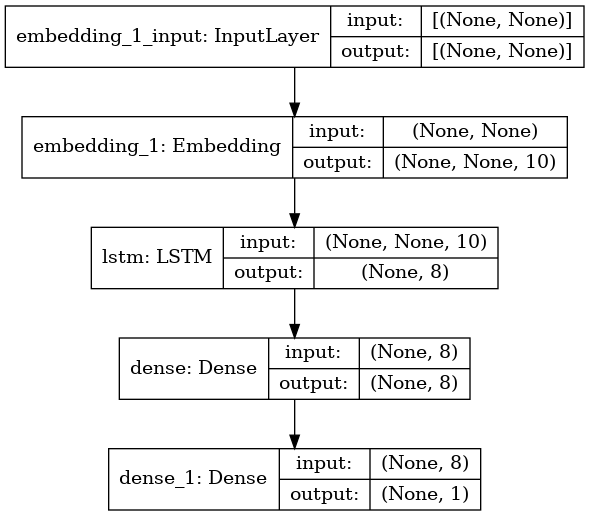

In [20]:
from keras.utils.vis_utils import plot_model #순서도로 시각화 해주는 기능이 있어 실습해보았다
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

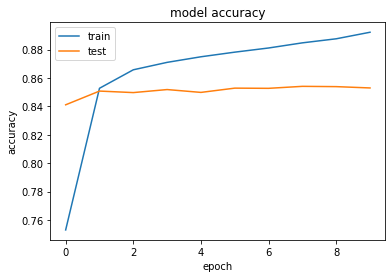

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

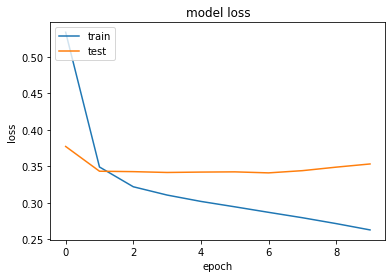

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
#다른 모델 돌려보기

vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 1, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          272       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

epochs=20

In [25]:
history = model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(x_validation, y_validation),verbose=1)


Epoch 1/20
257/257 [==============================] - 3s 5ms/step - loss: 0.5073 - accuracy: 0.7614 - val_loss: 0.3840 - val_accuracy: 0.8287
Epoch 2/20
257/257 [==============================] - 1s 4ms/step - loss: 0.3537 - accuracy: 0.8464 - val_loss: 0.3657 - val_accuracy: 0.8389
Epoch 3/20
257/257 [==============================] - 1s 4ms/step - loss: 0.3214 - accuracy: 0.8645 - val_loss: 0.3675 - val_accuracy: 0.8371
Epoch 4/20
257/257 [==============================] - 1s 4ms/step - loss: 0.3010 - accuracy: 0.8749 - val_loss: 0.3727 - val_accuracy: 0.8347
Epoch 5/20
257/257 [==============================] - 1s 4ms/step - loss: 0.2843 - accuracy: 0.8835 - val_loss: 0.3777 - val_accuracy: 0.8343
Epoch 6/20
257/257 [==============================] - 1s 4ms/step - loss: 0.2701 - accuracy: 0.8906 - val_loss: 0.3835 - val_accuracy: 0.8327
Epoch 7/20
257/257 [==============================] - 1s 4ms/step - loss: 0.2558 - accuracy: 0.8975 - val_loss: 0.3943 - val_accuracy: 0.8330
Epoch 

In [26]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6165 - accuracy: 0.8105
[0.6165074110031128, 0.810545802116394]


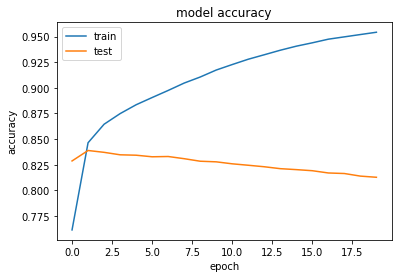

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

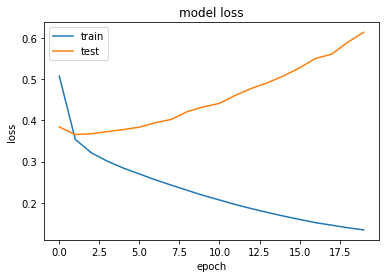

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
#또 다른 모델 시도하기

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 400   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 400)         4000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 3208      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 4,003,217
Trainable params: 4,003,217
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

epochs=20

In [31]:
history = model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(x_validation, y_validation),verbose=1)

Epoch 1/20
257/257 [==============================] - 2s 7ms/step - loss: 0.4452 - accuracy: 0.8085 - val_loss: 0.3362 - val_accuracy: 0.8507
Epoch 2/20
257/257 [==============================] - 2s 6ms/step - loss: 0.3035 - accuracy: 0.8729 - val_loss: 0.3274 - val_accuracy: 0.8573
Epoch 3/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2539 - accuracy: 0.8978 - val_loss: 0.3356 - val_accuracy: 0.8564
Epoch 4/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2074 - accuracy: 0.9214 - val_loss: 0.3558 - val_accuracy: 0.8545
Epoch 5/20
257/257 [==============================] - 2s 6ms/step - loss: 0.1581 - accuracy: 0.9444 - val_loss: 0.3834 - val_accuracy: 0.8546
Epoch 6/20
257/257 [==============================] - 2s 6ms/step - loss: 0.1104 - accuracy: 0.9662 - val_loss: 0.4282 - val_accuracy: 0.8506
Epoch 7/20
257/257 [==============================] - 2s 6ms/step - loss: 0.0717 - accuracy: 0.9808 - val_loss: 0.4709 - val_accuracy: 0.8491
Epoch 

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8210 - accuracy: 0.8408
[0.8210379481315613, 0.8407958149909973]


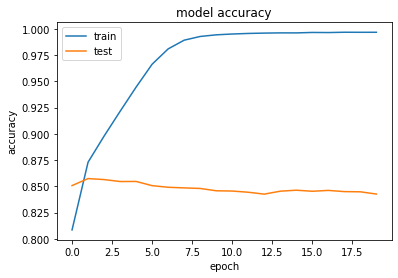

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

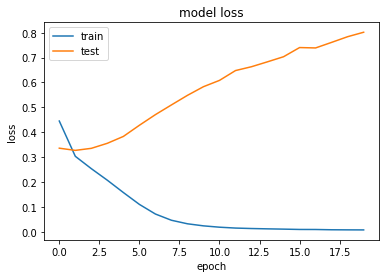

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 400)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([ 9.96034443e-02,  1.74057141e-01, -3.22871283e-02, -3.57758813e-02,
        1.12056956e-01,  1.20552525e-01,  2.00526595e-01, -1.39714144e-02,
       -4.35667038e-02, -2.32877978e-03, -2.41924934e-02,  4.84228618e-02,
        3.73703204e-02, -6.70993775e-02,  2.04373766e-02,  2.58330256e-02,
        1.13729268e-01,  1.12248063e-01,  1.77698657e-01, -1.68265437e-03,
        1.44990116e-01,  6.24165731e-03,  8.11260864e-02,  1.28112689e-01,
       -1.52003756e-02,  1.36486396e-01, -1.62255613e-03, -7.64443725e-03,
       -6.94201812e-02,  1.61785726e-02, -2.59271841e-02,  6.69630617e-03,
        9.78193209e-02, -8.48330185e-03, -2.30980199e-02, -2.80398992e-03,
        6.47311136e-02, -4.24951166e-02, -4.15162928e-02, -2.29281951e-02,
        1.53260097e-01,  1.07135504e-01, -5.49122971e-03,  1.37654409e-01,
        3.06647755e-02, -2.96630729e-02,  4.64671180e-02,  7.28683127e-03,
        4.80774930e-03,  2.04452723e-01, -3.03120743e-02,  1.69523120e-01,
       -5.92227913e-02,  

In [38]:
word_vectors.similar_by_word("love")

[('잼따', 0.7262195944786072),
 ('멋져요', 0.7155186533927917),
 ('아름다워요', 0.7105897665023804),
 ('조음', 0.7059292793273926),
 ('！', 0.7032471299171448),
 ('great', 0.6873793005943298),
 ('슬퍼요', 0.6866161823272705),
 ('♥♥♥♥', 0.6850271224975586),
 ('고마워요', 0.6717073917388916),
 ('이제서야', 0.6644280552864075)]

In [39]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector 



array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [40]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_validation, y_validation),
                    verbose=1)

Epoch 1/10
257/257 [==============================] - 3s 9ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 2/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 3/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 4/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 5/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 6/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 7/10
257/257 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 

In [44]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6932 - accuracy: 0.4973
[0.6931893825531006, 0.4973045587539673]


#### 회고: 
이번 exploration도 어려웠다. 설명에 없었던 history 사용해서 accuracy, loss 값을 그래프로 그리느라 시간을 많이 잡아먹었지만 이렇게 더 배우게 되는 것 같다. 
    Gensim은 한국어 ko.bin 다운로드까지 했는데 gensim 버전 낮추는 법을 못 찾아 한국어로 돌려보기는 아직 못해봤다. ㅠ 
    그리고 하이퍼파라미터 설정은 여전히 너무 어렵다. 
    한가지 더, 리뷰 데이터를 시계열 데이터로 바라보는 관점도 새로웠다.  